In [1]:
import matplotlib.pyplot as plt
import numpy as np
import galsim
from astropy.io import fits
import glob
import sys
sys.path.append('../')
from diverse_utils import sim_field, sim_and_save_field
from astropy.visualization import ZScaleInterval

from telescopes.main_info import info
%load_ext autoreload
%autoreload 2

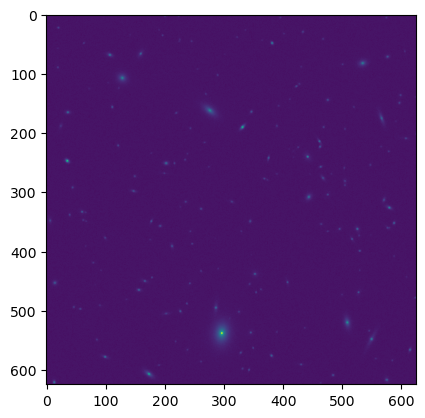

In [2]:
sim_and_save_field(info, 'Euclid', 'VIS', 'Wide-Survey', show=True)

In [7]:
sim_and_save_field(info, 'Euclid', 'NIR', 'Wide-Survey', show=True)

NameError: name 'galsim' is not defined

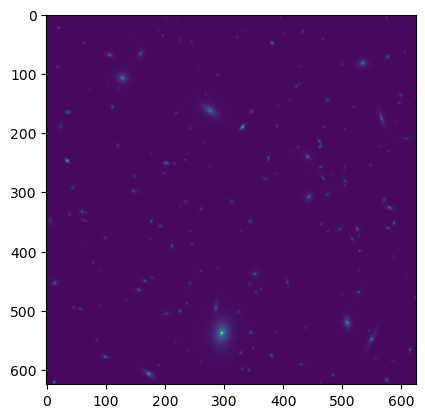

In [3]:
sim_and_save_field(info, 'Euclid', 'VIS', 'Deep-Survey', show=True)

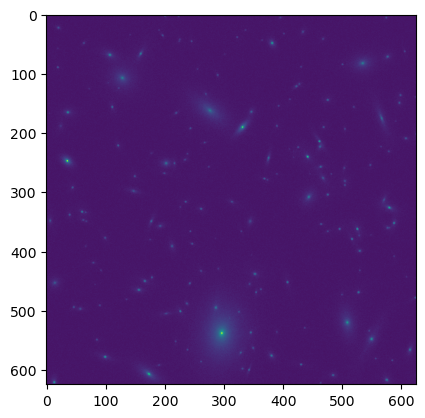

In [4]:
sim_and_save_field(info, 'JWST', 'NIRCAM', 'Cosmos-Web', show=True)

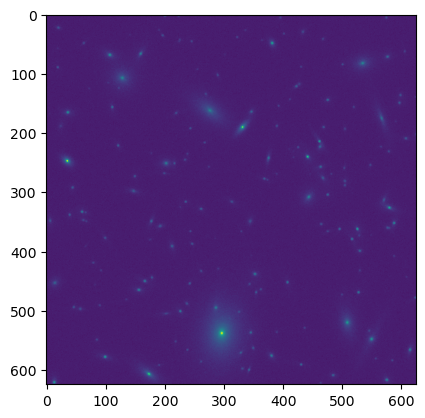

In [5]:
sim_and_save_field(info, 'HST', 'ACS', 'HST-Cosmos', show=True)

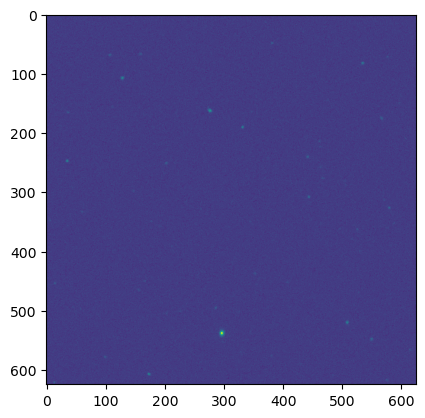

In [6]:
sim_and_save_field(info, 'SDSS', 'Imaging_camera', 'SDSS-I', show=True)

In [16]:
telecope = 'Euclid'
survey = 'Wide-Survey'
instrument = 'VIS'

pix = info[telecope]['surveys'][survey]['instruments'][instrument]['pix_scale']
main_band = info[telecope]['surveys'][survey]['instruments'][instrument]['main_band']
zp = info[telecope]['surveys'][survey]['instruments'][instrument]['bands'][main_band]['zp']
sensitivity = info[telecope]['surveys'][survey]['sensitivity']
fwhm = info[telecope]['surveys'][survey]['instruments'][instrument]['bands'][main_band]['fwhm']

In [17]:
euclid_info = info['Euclid']
euclid = sim_field(pix, fwhm, zp, sensitivity)

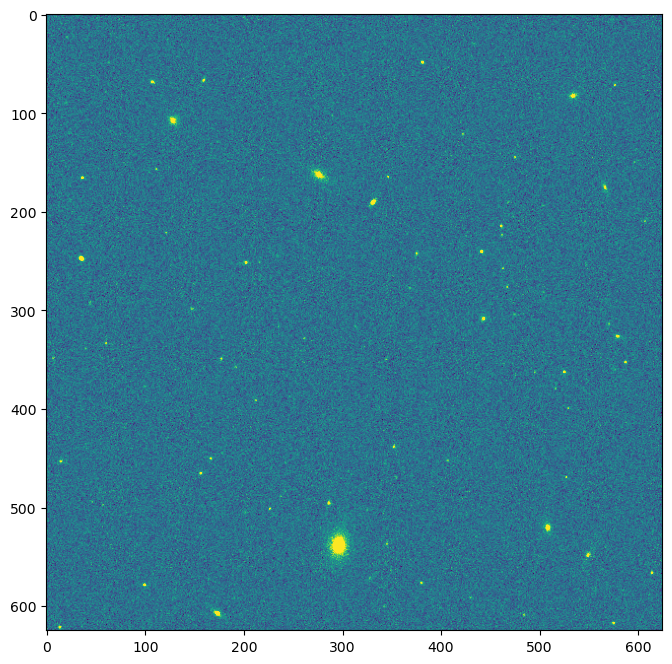

In [18]:
interval = ZScaleInterval()
a = interval.get_limits(euclid)
plt.figure(figsize=(8, 8))
plt.imshow(euclid, vmin=a[0], vmax=a[1])


In [ ]:
telecope = 'Euclid'
survey = 'Wide-Survey'
instrument = 'VIS'

pix = info[telecope]['surveys'][survey]['instruments'][instrument]['pix_scale']
main_band = info[telecope]['surveys'][survey]['instruments'][instrument]['main_band']
zp = info[telecope]['surveys'][survey]['instruments'][instrument]['bands'][main_band]['zp']
sensitivity = info[telecope]['surveys'][survey]['sensitivity']
fwhm = info[telecope]['surveys'][survey]['instruments'][instrument]['bands'][main_band]['fwhm']

In [15]:
sim_and_save_field(info, 'HST', 'ACS', 'HST-Cosmos', show=True)

KeyError: 'sensitivity'

In [ ]:
sim_and_save_field('SDSS', 'Imaging_camera', 'SDSS-I', show=True)

In [ ]:
sim_and_save_field('Euclid', 'VIS', 'Deep-Survey', show=True)


In [7]:
sim_and_save('Euclid', 'NIR', 'Deep-Survey')

In [8]:
sim_and_save('Euclid', 'NIR', 'Wide-Survey')

In [6]:
sim_and_save('JWST', 'NIRCAM', 'Cosmos-Web')

KeyError: 'main_band'

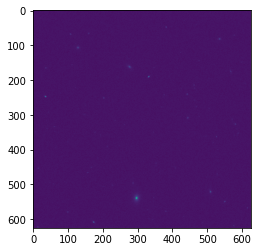

In [7]:
image = sim_field(cat, instrument_info['pix_scale'],
                instrument_info['bands'][band]['fwhm'],
                info[telescope]['surveys'][survey]['std_noise'],
                instrument_info['bands'][band]['zp'])
plt.imshow(image)
fits.writeto('../data/Euclid_VIS_Wide-Survey.fits', image, overwrite=True)


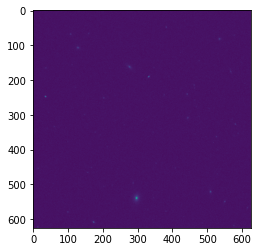

In [7]:
image = sim_field(cat, 0.1, 0.17, 0.003, 25.9)
plt.imshow(image)
fits.writeto('../data/fields/Euclid_VIS_Wide-Survey.fits', image, overwrite=True)


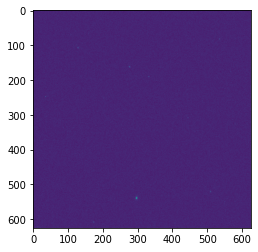

In [8]:
image = sim_field(cat, 0.3, 0.2, 0.012, 25.26)
plt.imshow(image)
fits.writeto('../data/fields/Euclid_NIR_Wide-Survey.fits', image, overwrite=True)


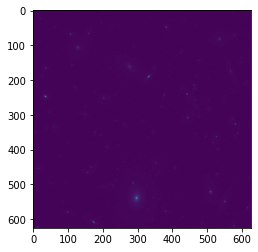

In [6]:
image = sim_field(cat, 0.031, 0.02, 0.0007, 27.1) #zp f277w
plt.imshow(image)
fits.writeto('../data/fields/JWST_NIRCAM_Cosmos-Web.fits', image, overwrite=True)


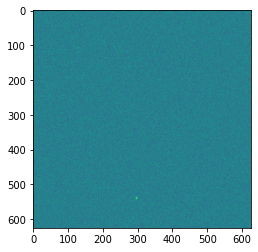

In [11]:
image = sim_field(cat, 0.4, 1.15, 0.093, 24.8)
plt.imshow(image)
fits.writeto('../data/fields/SDSS_Imaging_camera_SDSS-I.fits', image, overwrite=True)


In [ ]:
mv ScribdDocument